# Cluster images based on DINOv2 features

In [1]:
import os
import faiss
import torch
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import transforms
from tqdm.notebook import tqdm
from kiss.feature_extractor import FeatureExtractor

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
device = torch.device('mps')
feature_extractor = FeatureExtractor(device=device)

/Users/michal/mambaforge/envs/kiss/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
Using cache found in /Users/michal/.cache/torch/hub/facebookresearch_dinov2_main
/Users/michal/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/Users/michal/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/Users/michal/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


## Load dataset

In [2]:
EMBEDDING_SIZE = 384
BATCH_SIZE = 32
SAMPLES_PER_CLASS = 200

# transform = transforms.Compose([transforms.ToTensor()])
# train_dataset = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
# CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# train_targets = train_dataset.targets

transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.SVHN(root='../data', split='train', download=True, transform=transform)
CLASSES = [f'number {i}' for i in range(10)]
train_targets = train_dataset.labels

N_CLASSES = len(CLASSES)

train_indices = []

for class_label in range(N_CLASSES):
    class_indices = [i for i, label in enumerate(train_targets) if label == class_label]
    train_indices.extend(class_indices[:SAMPLES_PER_CLASS])

train_set = torch.utils.data.Subset(train_dataset, train_indices)
trainloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Using downloaded and verified file: ../data/train_32x32.mat


## Extract features from images

In [3]:
img_features = np.zeros((SAMPLES_PER_CLASS * N_CLASSES, EMBEDDING_SIZE))
img_labels = np.zeros((SAMPLES_PER_CLASS * N_CLASSES,))

for i, (imgs, labels) in tqdm(enumerate(trainloader), total=SAMPLES_PER_CLASS*N_CLASSES//BATCH_SIZE):
    feats = feature_extractor(imgs)
    feats = np.float32(feats)
    faiss.normalize_L2(feats)
    img_features[i*BATCH_SIZE: i*BATCH_SIZE+BATCH_SIZE] = feats
    img_labels[i*BATCH_SIZE: i*BATCH_SIZE+BATCH_SIZE] = labels

/Users/michal/mambaforge/envs/kiss/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/michal/mambaforge/envs/kiss/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


  0%|          | 0/62 [00:00<?, ?it/s]

## Use K-means to cluster images

In [8]:
K = N_CLASSES
kmeans = faiss.Kmeans(d=EMBEDDING_SIZE, k=K, niter=20)
kmeans.train(img_features)
_, I = kmeans.index.search(img_features, 1)

I = I.flatten()

## Count number each class is assigned to each cluster

In [9]:
counts = np.zeros((N_CLASSES, K), dtype=int)

for i in range(N_CLASSES):
    for j in range(K):
        count = np.sum((img_labels == i) & (I == j))
        counts[i, j] = count

df = pd.DataFrame(counts, index=CLASSES, columns=np.unique(I))
df

,0,1,2,3,4,5,6,7,8,9
number 0,29,20,35,18,22,17,23,11,10,15
number 1,29,6,18,13,39,13,12,30,16,24
number 2,23,12,24,11,12,26,25,25,19,23
number 3,21,31,22,8,15,19,32,18,9,25
number 4,25,9,25,21,20,9,10,30,25,26
number 5,28,18,17,9,17,12,36,20,22,21
number 6,24,20,39,9,6,23,28,17,17,17
number 7,27,10,18,20,22,18,19,27,21,18
number 8,26,25,20,14,17,25,28,15,12,18
number 9,23,28,21,13,12,22,21,18,20,22


## Plot selected class images from each cluster

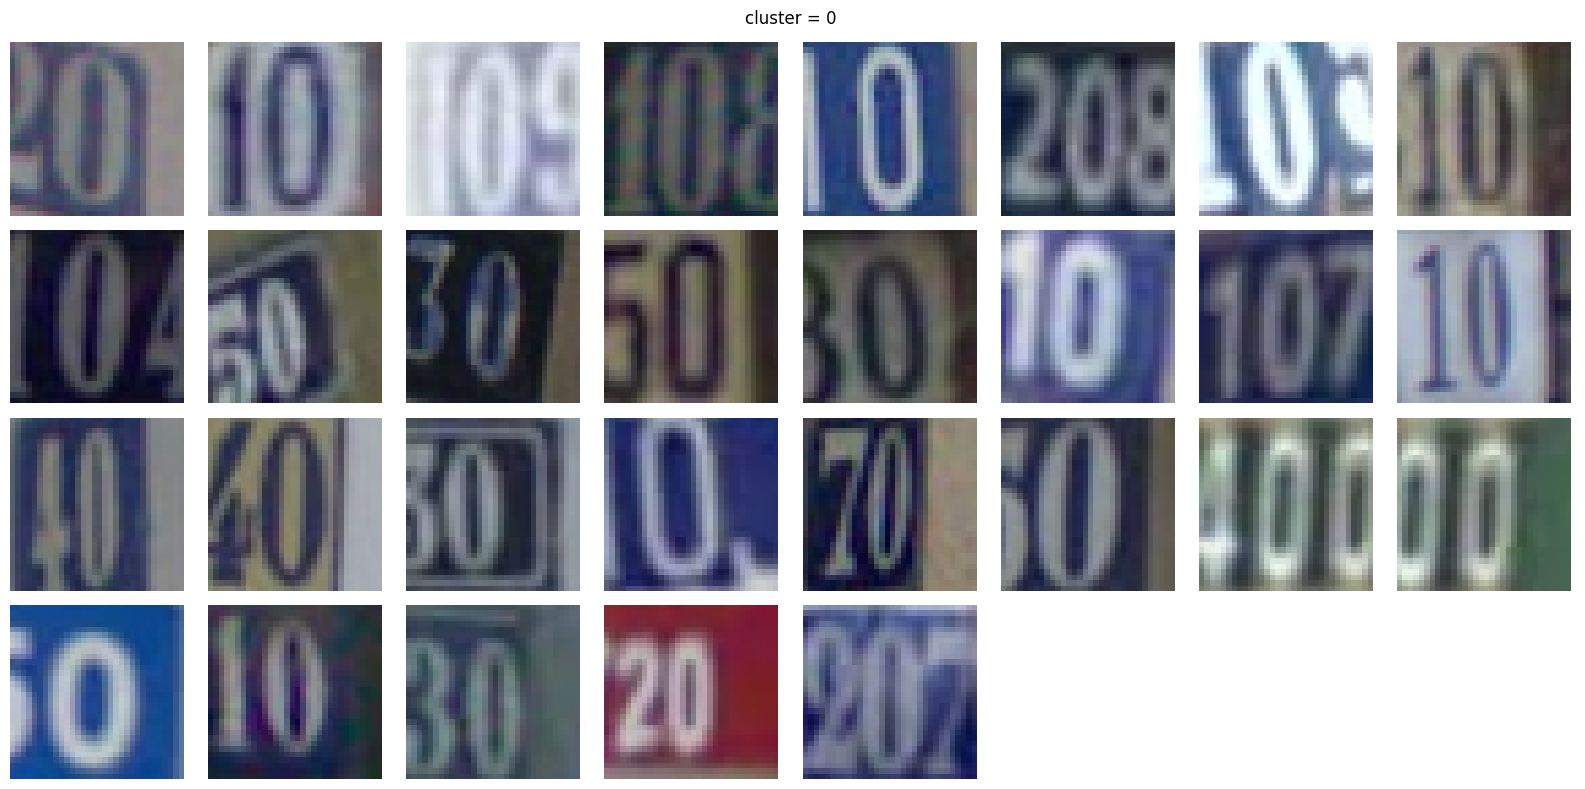

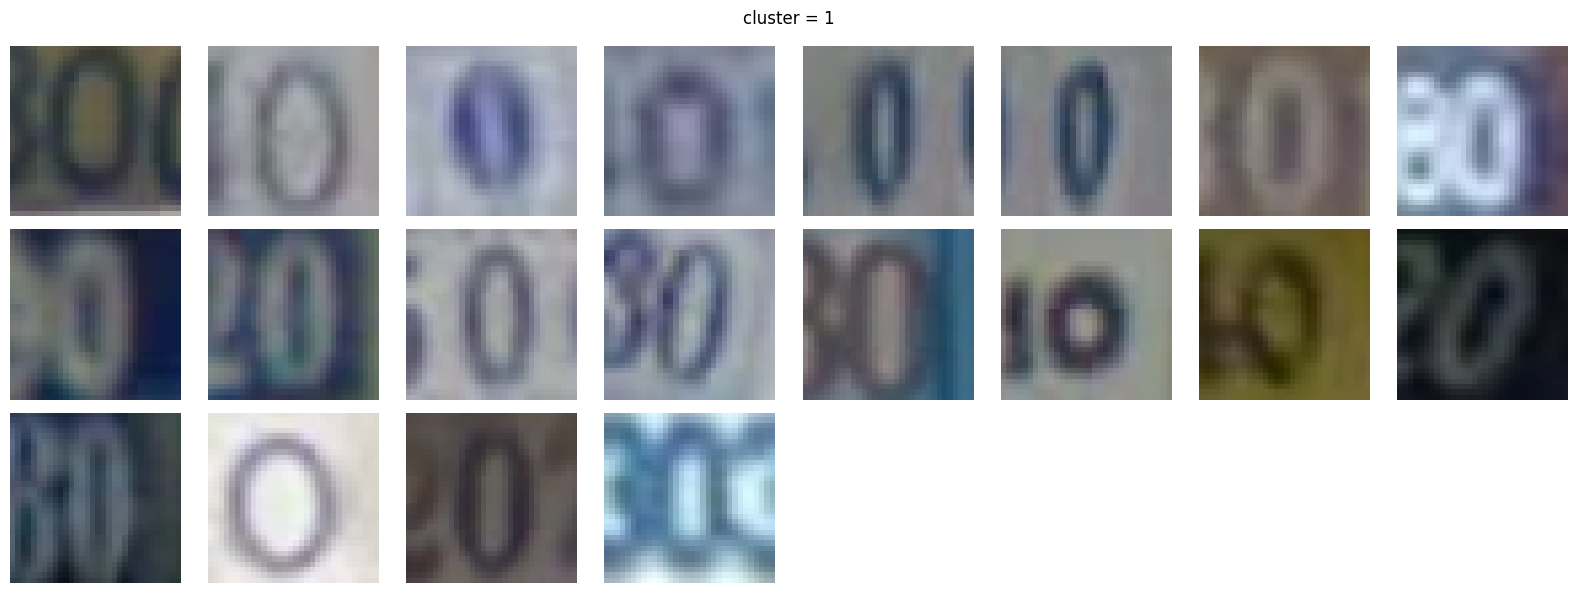

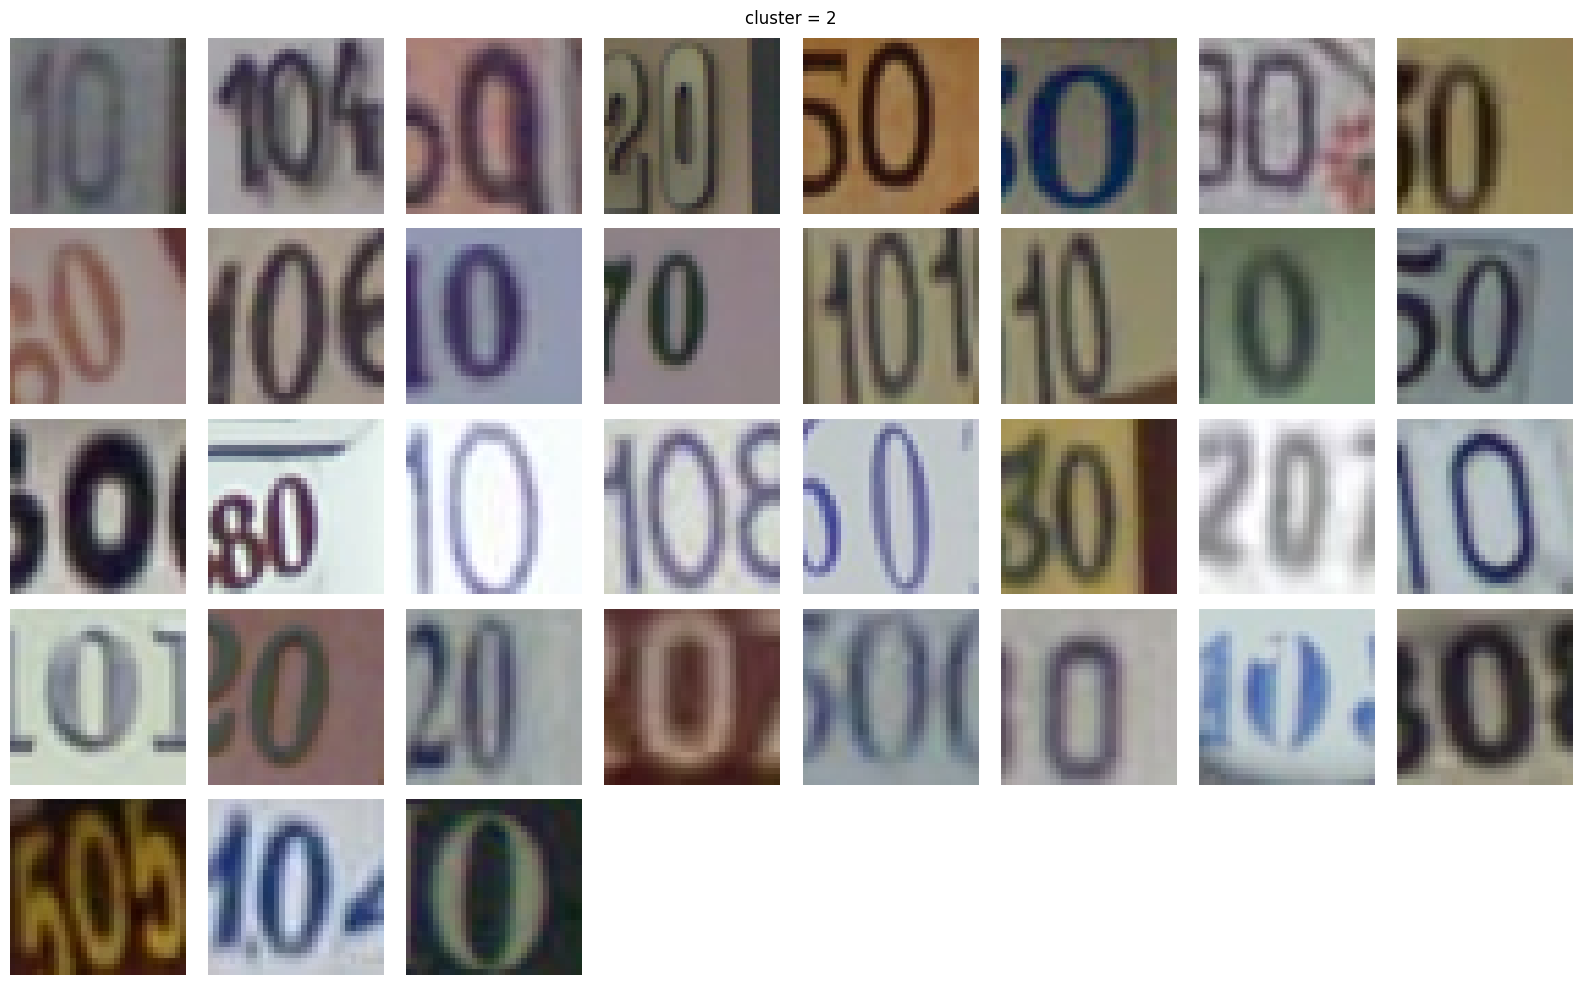

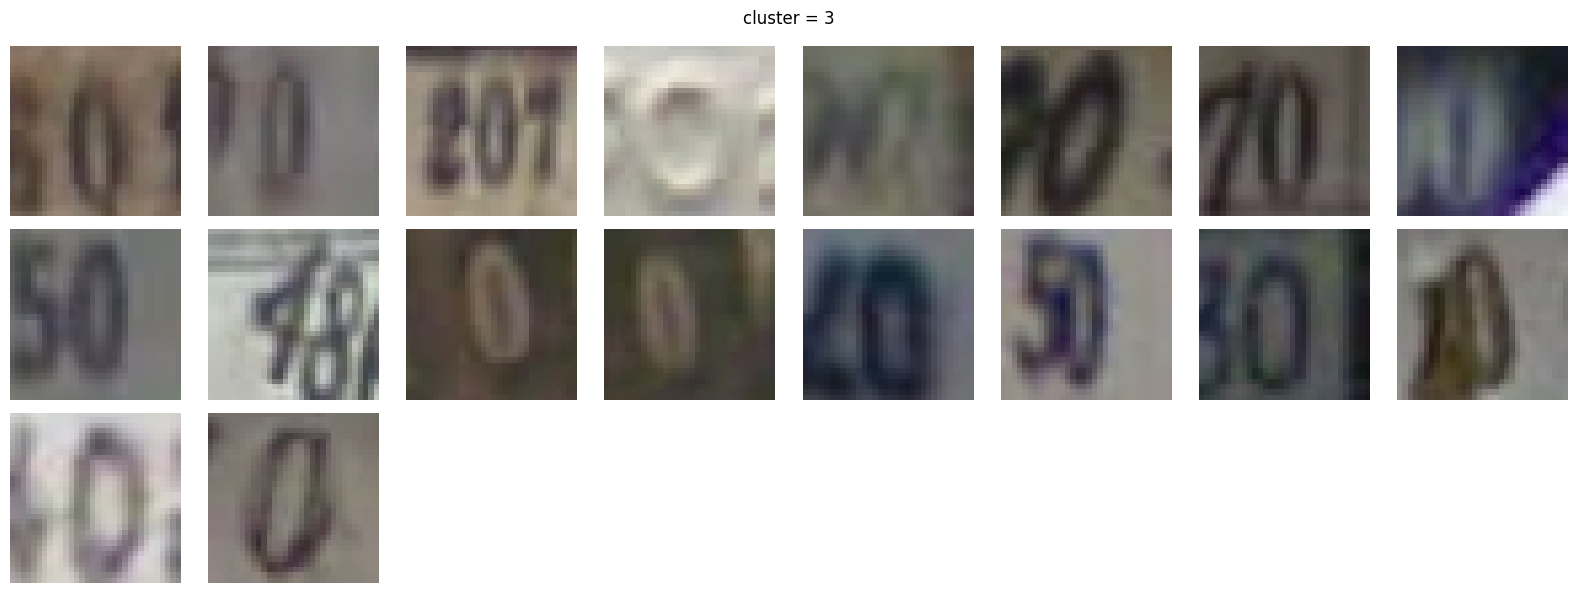

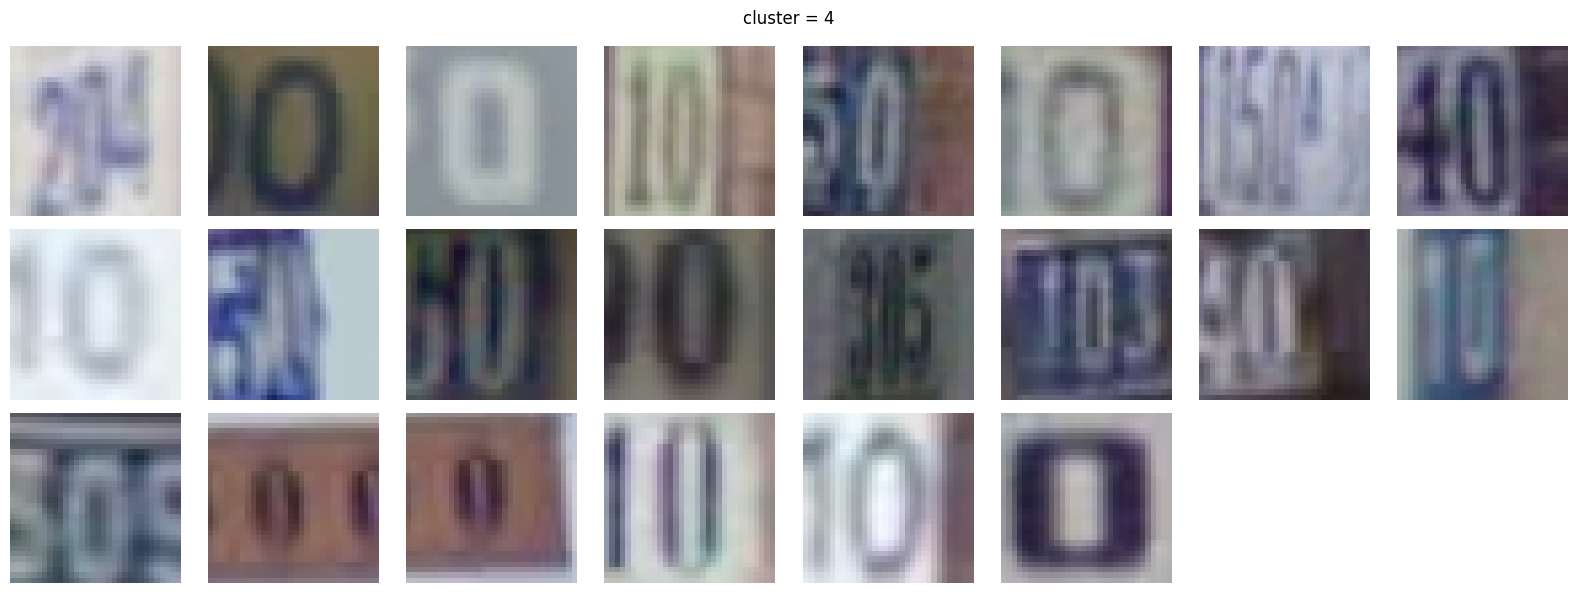

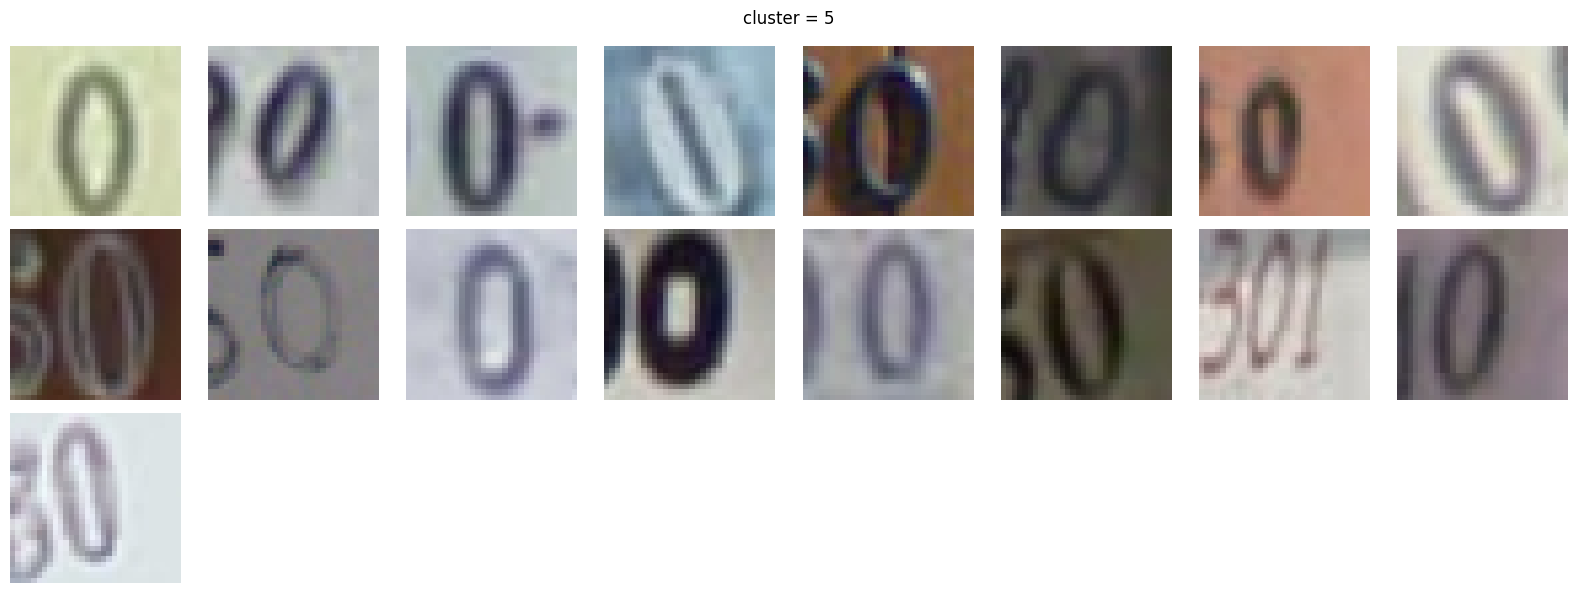

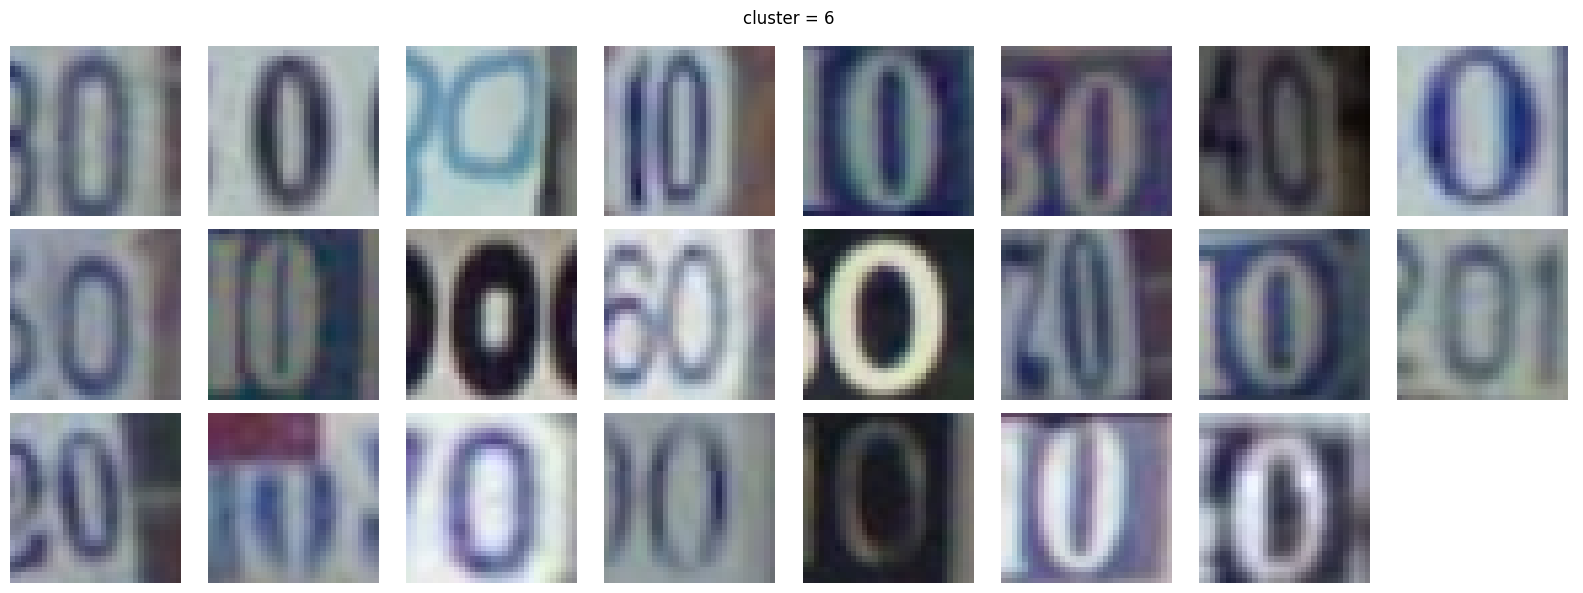

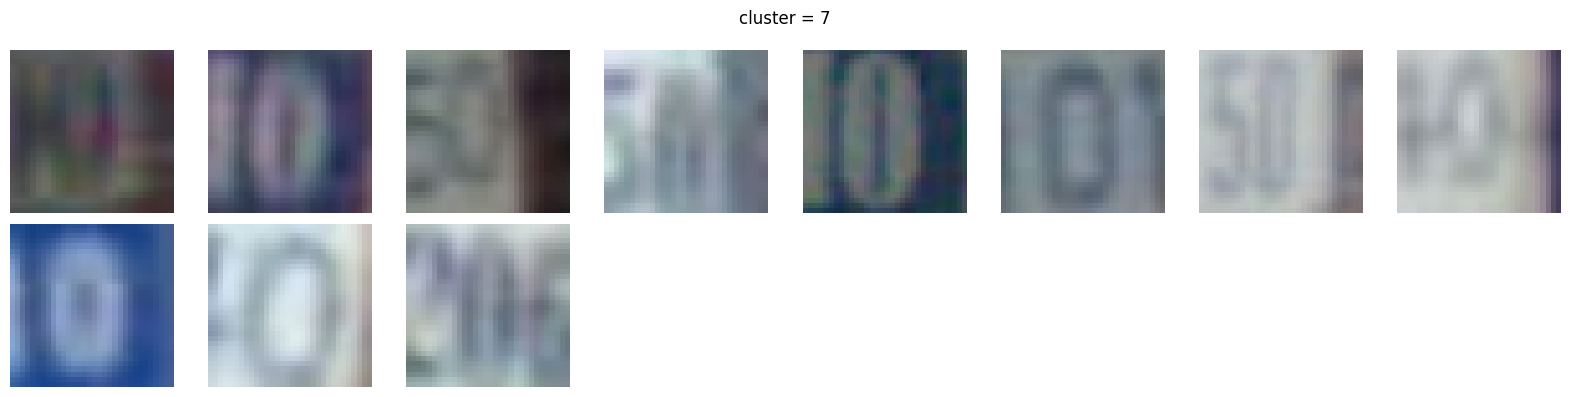

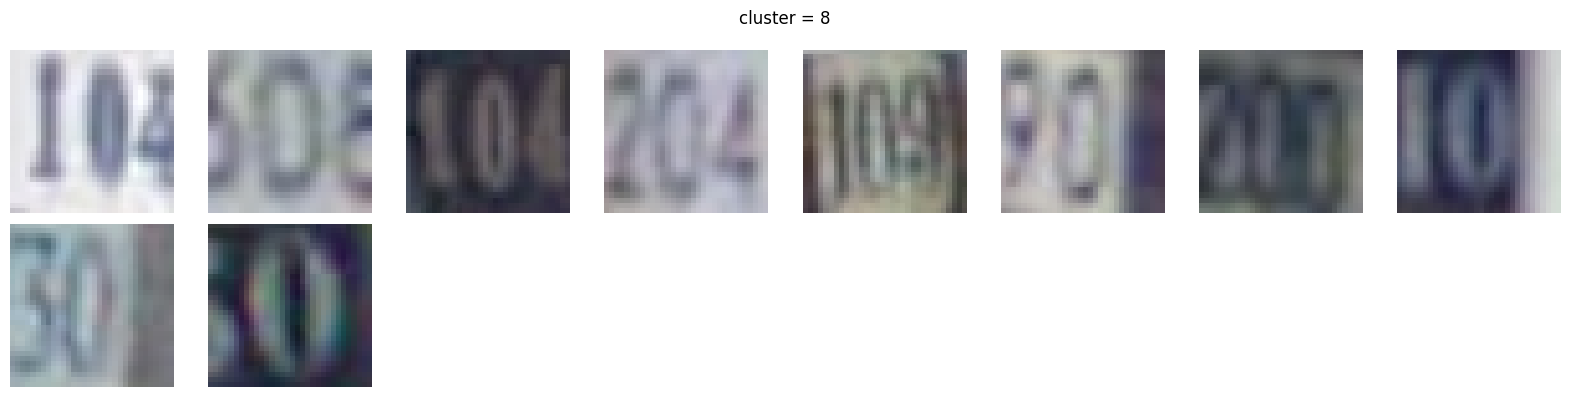

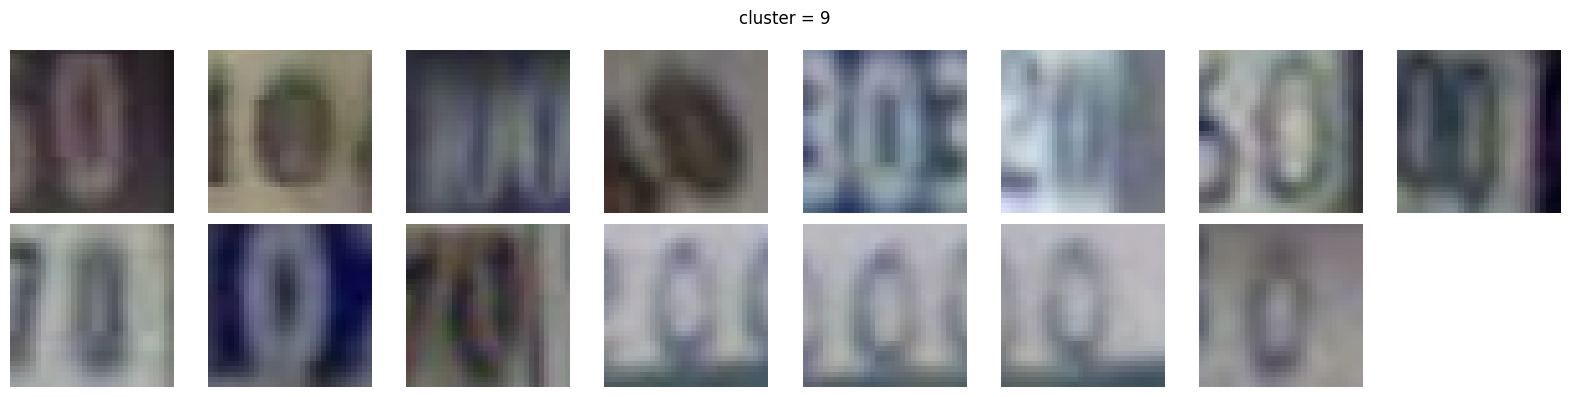

In [10]:
class_to_plot = 'number 0'

for cluster_num in range(K):
    idxs = np.where((img_labels == CLASSES.index(class_to_plot)) & (I == cluster_num))[0]

    if len(idxs) == 0:
        continue

    # Calculate the number of columns in the grid
    n_cols = 8
    n_rows = int(np.ceil(len(idxs) / n_cols))  # Round up division

    # Set up the subplots for the grid
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 2 * n_rows))
    plt.suptitle(f'cluster = {cluster_num}')

    # Loop through the indices and display images in the grid
    for i, img_idx in enumerate(idxs):
        row, col = divmod(i, n_cols)
        ax = axes[row, col] if n_rows > 1 else axes[col]
        
        img, label = train_set[img_idx]
        im = transforms.ToPILImage()(img)  # Convert the Tensor to a PIL Image
        ax.imshow(im)
        ax.axis('off')

    # Remove empty subplots if necessary
    for i in range(len(idxs), n_rows * n_cols):
        row, col = divmod(i, n_cols)
        ax = axes[row, col] if n_rows > 1 else axes[col]
        ax.axis('off')

    # Adjust layout to prevent clipping of subplots
    plt.tight_layout()
    plt.show()